# TCLab PID


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime
import tclab
import time

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT

import package_JM_RS
from package_JM_RS import PID_RT, LL_RT,IMC_Tuning

# LL_RT()

# PID_RT()

# Parameters

In [2]:
Tsim = 2200
Ts = 1
N = int(Tsim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 65

Kp = 0.5194904467673822
T1p = 129.9860279570493
T2p = 2.2419668343920548e-08 # Bizarre => à verifier
thetap = 7.219217782540495

Kd = 0.5066617883318505
T1d = 198.90601996256459
T2d = 8.124468051389487
thetad = 1.0918143519352412

Kc,Ti,Td = IMC_Tuning(Kp,T1p,T2p,thetap)
alpha = 0.5
MVMin = 0
MVMax = 500

# Inputs


In [3]:
#1 OLP + no FF

# ManPath = {0 : True,Tsim : True}
# MVManPath = {0 : MV0, Tsim : MV0}
# SPPath = {0 : PV0, 800 : PV0}
# DVPath = {0 : 50, 1000 : 60, Tsim : 60}
# ActivateFF = False
# ManFF = True

#2 OLP + FF

# ManPath = {0 : True,Tsim : False}
# MVManPath = {0 : MV0, Tsim : MV0}
# SPPath = {0 : PV0, 800 : PV0}
# DVPath = {0 : 50, 1000 : 60, Tsim : 60}
# ActivateFF = True
# ManFF = True

#3 CLP + no FF

# ManPath = {0 : True, 750: False, Tsim : False}
# MVManPath = {0 : MV0, Tsim : MV0}
# SPPath = {0 : PV0, 800 : PV0-10, Tsim : PV0-10}
# DVPath = {0 : DV0, 1500 : DV0+10, Tsim : DV0+10}
# ActivateFF = False
# ManFF = False

#4 CLP + FF

ManPath = {0 : True, 750: False, Tsim : False}
MVManPath = {0 : MV0, Tsim : MV0}
SPPath = {0 : PV0, 800 : PV0-10, Tsim : PV0-10}
DVPath = {0 : DV0, 1500 : DV0+10, Tsim : DV0+10}
ActivateFF = True
ManFF = False

# Simulation Real Time 

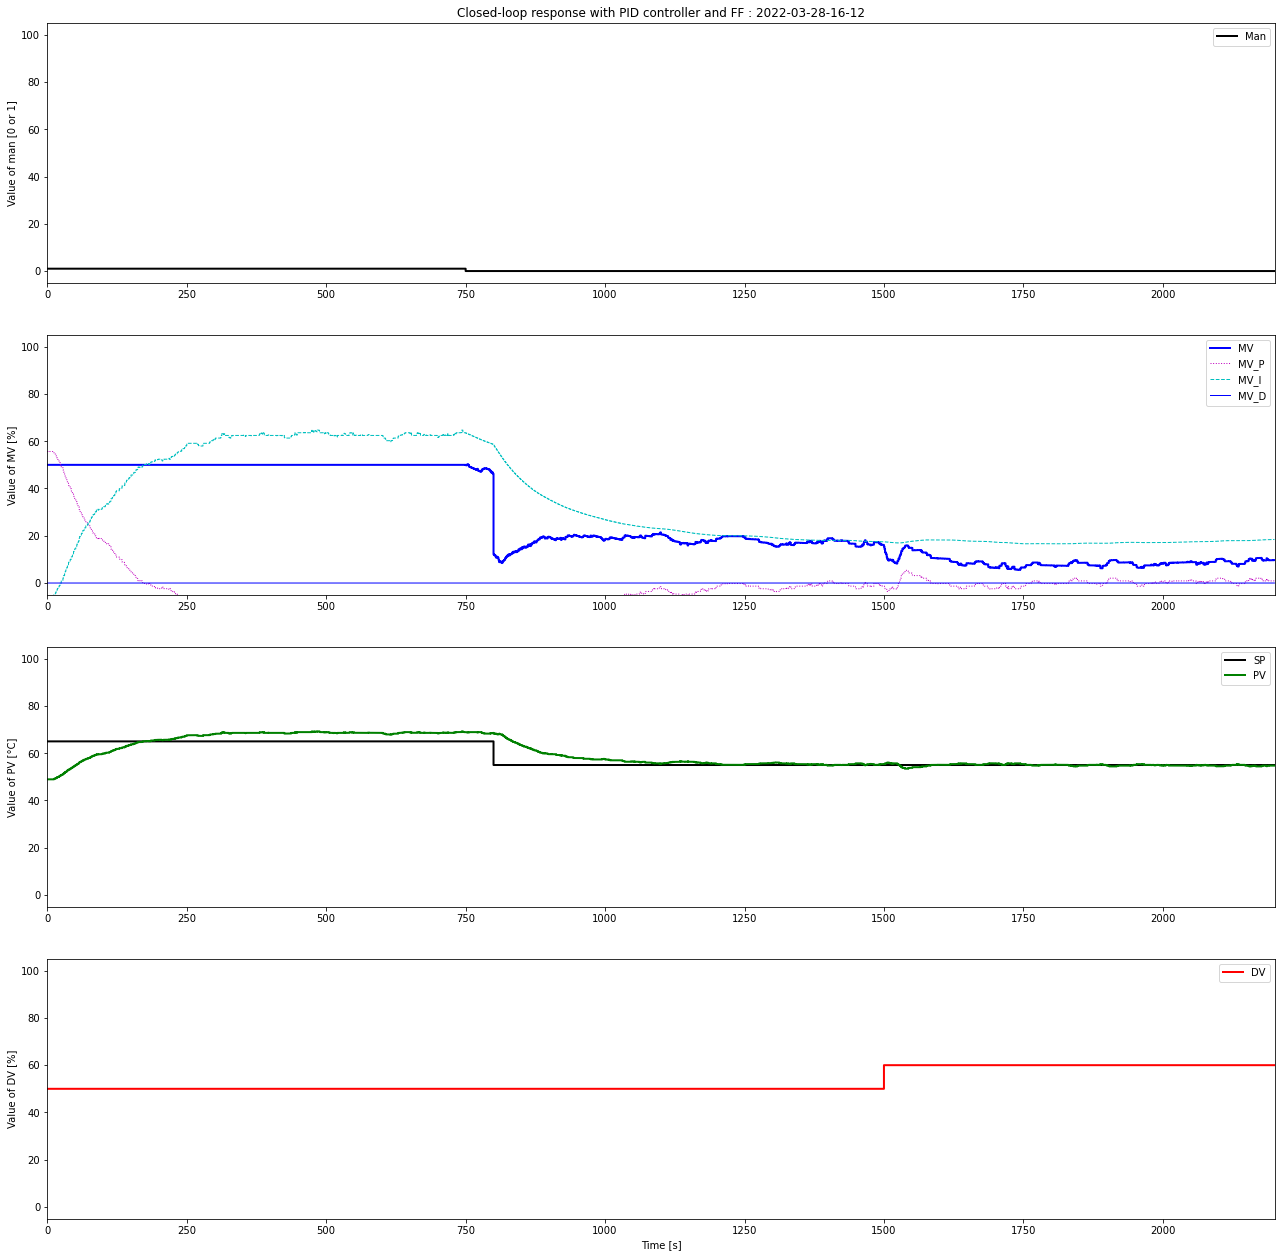

TCLab disconnected successfully.


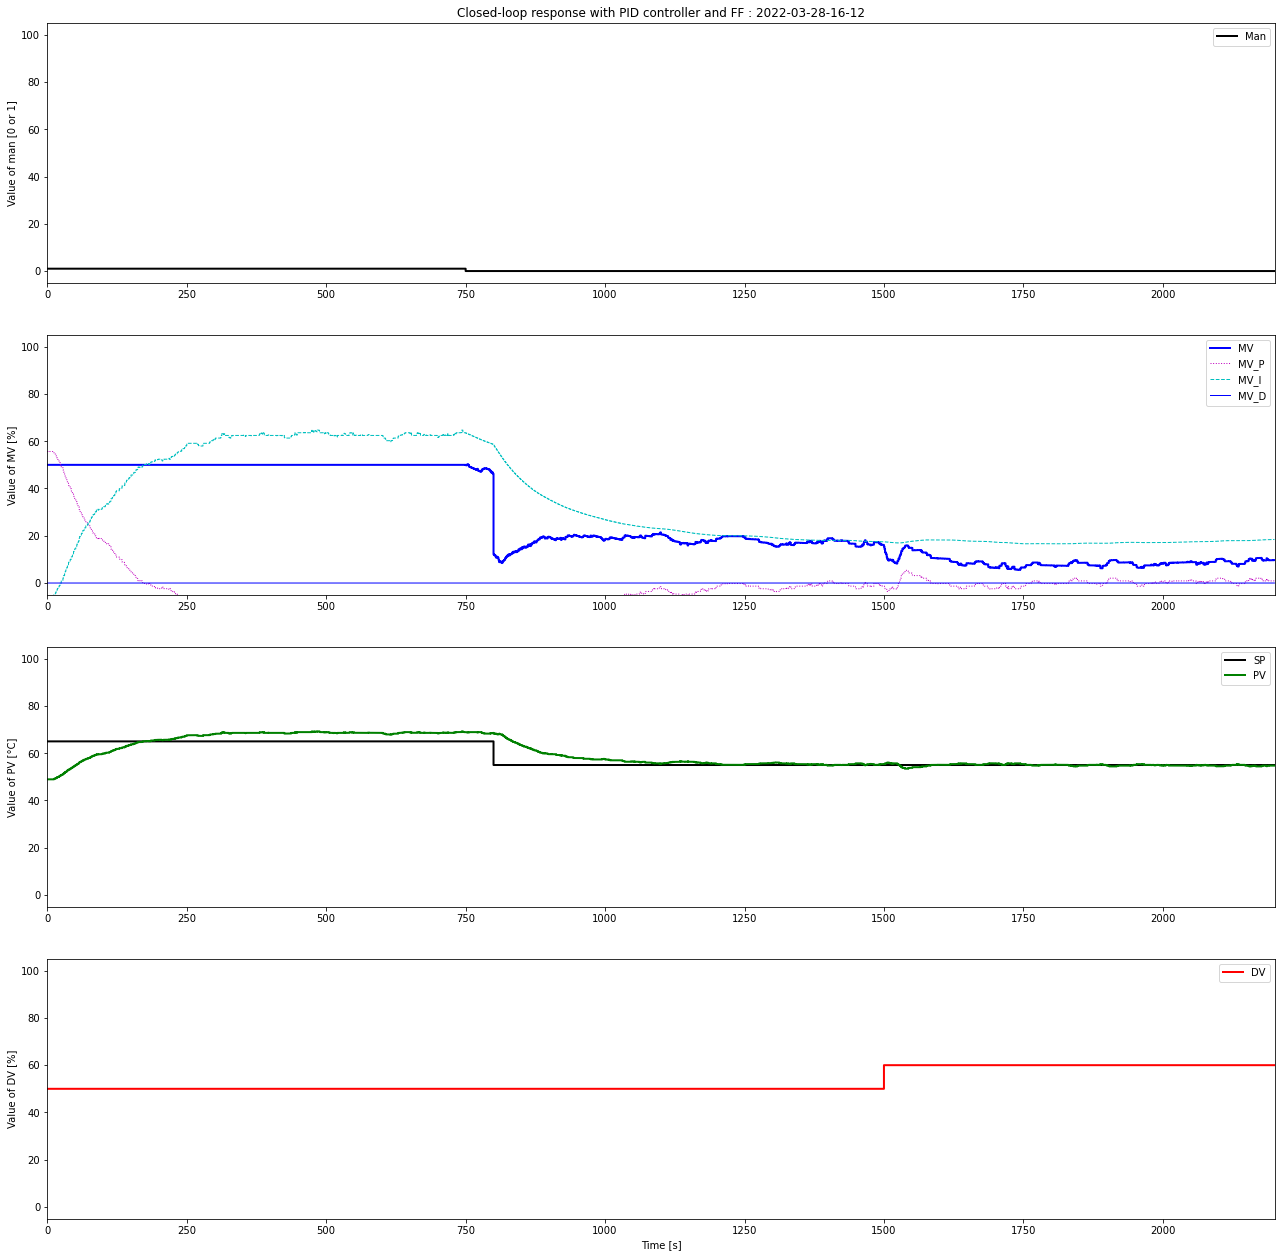

In [4]:
t = []
SP = [] 
MV = [] 
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = [] 
PV = [] 
E = []

MVFFDelay = []
MVFFLL1 = [] 

lab = tclab.TCLab()

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%H-%M")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
fig.set_figheight(22)
fig.set_figwidth(22)

l1, = ax1.step([0,Tsim],[0,100],'k-',linewidth=2,label='Man',where='post')
ax1.set_ylabel('Value of man [0 or 1]')
ax1.set_title('Closed-loop response with PID controller and FF : ' + date_time)
ax1.legend(loc='best')

l2, = ax2.step([0,Tsim],[0,100],'b-',linewidth=2,label='MV',where='post')
l3, = ax2.step([0,Tsim],[0,100],'m:',linewidth=1,label='MV_P',where='post')
l4, = ax2.step([0,Tsim],[0,100],'c--',linewidth=1,label='MV_I',where='post')
l5, = ax2.step([0,Tsim],[0,100],'b-',linewidth=1,label='MV_D',where='post')
ax2.set_ylabel('Value of MV [%]')
ax2.legend(loc='best')

l6, = ax3.step([0,Tsim],[0,100],'k-',linewidth=2,label='SP',where='post')
l7, = ax3.step([0,Tsim],[0,100],'g-',linewidth=2,label='PV',where='post')
ax3.set_ylabel('Value of PV [°C]')
ax3.legend(loc='best')

l8, = ax4.step([0,Tsim],[0,100],'r-',linewidth=2,label='DV',where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Value of DV [%]')
ax4.legend(loc='best')

for i in range(0,N): 
    t.append(i*Ts)

    PV.append(lab.T1)

    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)

    lab.Q2(DV[-1])

    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LL_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)

    if ActivateFF:
        LL_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
    else: 
        LL_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)

    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)

    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha, Ts,MVMin,MVMax,MV,MVP,MVI,MVD, E ,ManFF)

    lab.Q1(MV[-1])

    time.sleep(Ts)

    l1.set_data(t,Man)
    l2.set_data(t,MV)
    l3.set_data(t,MVP)
    l4.set_data(t,MVI)
    l5.set_data(t,MVD)
    l6.set_data(t,SP)
    l7.set_data(t,PV)
    l8.set_data(t,DV)

    clear_output(wait=True)

    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)

    display(fig)
lab.close()
#Save Draw

t = np.array(t)
MV = np.array(MV)
MVP = np.array(MVP)
MVI = np.array(MVI)
MVD = np.array(MVD)
SP = np.array(SP)
PV = np.array(PV)
DV = np.array(DV)
Man = np.array(Man)
my_data = np.vstack((t.T,MV.T, MVP.T, MVI.T, MVD.T, SP.T, PV.T, DV.T, Man.T))
my_data = my_data.T
nameFile = 'Data/Closed_Loop_experiment_with_PID_and_FF_' + date_time + '.txt'
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,SP,PV,DV,Man',comments='')

    